# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

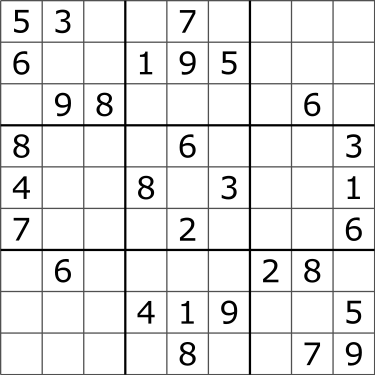

## Prepare environment

In [85]:
import kagglehub
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers, losses, metrics, models, callbacks, regularizers
import pathlib
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
import shutil

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
# 
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
# keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

### Hyperparameters

In [86]:
DATA_SIZE_LIMIT = 10_000 # TODO: return to None

BATCH_SIZE = 128 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 3 # TODO: return to 10

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

## Prepare dataset

### Download from Kaggle

In [87]:
path = kagglehub.dataset_download("rohanrao/sudoku")
print("Path to dataset files:", path)

Path to dataset files: /home/martin/.cache/kagglehub/datasets/rohanrao/sudoku/versions/1


In [88]:
os.listdir(path)

['sudoku.csv']

In [89]:
FILE_PATH = os.path.join(path, "sudoku.csv")

In [90]:
sudoku_text = pathlib.Path(FILE_PATH).read_text()

In [91]:
sudoku_lines = sudoku_text.split("\n")[1:-1]  # Drop header

del sudoku_text

In [92]:
if (DATA_SIZE_LIMIT != None):
    sudoku_lines = sudoku_lines[:DATA_SIZE_LIMIT]

In [93]:
full_dataset_size = len(sudoku_lines)
print(full_dataset_size)

10000


### Decode CSV to tensor list

In [94]:
sudoku_tensors = np.array(tf.io.decode_csv(sudoku_lines, record_defaults=[str()] * 2))
print(f"Decoded CSV shape: {sudoku_tensors.shape}")

del sudoku_lines

Decoded CSV shape: (2, 10000)


### Split train, validation and test sets based on difficulty

In [95]:
X_tensors, y_tensors = sudoku_tensors

In [96]:
def calculate_difficulties(X_tensors):
    # Count zero entries (given clues) - the more zeros the more difficult is the puzzle
    difficulties = np.array([puzzle.decode("utf-8").count("0") for puzzle in X_tensors])
    return difficulties

In [97]:
difficulties = calculate_difficulties(X_tensors)

# Replace difficulties with rare occurrence with the most common one so that we can split evenly
difficulty_counts = np.bincount(difficulties)
rare_difficulties = np.where(difficulty_counts < 10)[0]
most_common_difficulty = np.argmax(difficulty_counts)
difficulties = np.where(np.isin(difficulties, rare_difficulties), most_common_difficulty, difficulties)

print("Original difficulty distribution:", np.bincount(difficulties))

Original difficulty distribution: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  10  10  10  20  26  23  29  38  51  64  81 103 127 154 166 218 247
 277 341 419 472 507 532 637 679 710 826 665 685 598 435 351 247 149  72
  21]


In [98]:
train_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(train_sss.split(X_tensors, difficulties))
difficulties_train = difficulties[train_index]
difficulties_train_dist = np.round(100 * np.bincount(difficulties_train) / len(difficulties_train), 2)
print("Train difficulty distribution (percentage):", difficulties_train_dist)

X_train_tensors, X_temp, y_train_tensors, y_temp = X_tensors[train_index], X_tensors[test_index], y_tensors[train_index], y_tensors[test_index]
difficulties_temp = difficulties[test_index]

test_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(test_sss.split(X_temp, difficulties_temp))
X_val_tensors, X_test_tensors, y_val_tensors, y_test_tensors = X_temp[val_index], X_temp[test_index], y_temp[val_index], y_temp[test_index]

difficulties_val = difficulties_temp[val_index]
difficulties_val_dist = np.round(100 * np.bincount(difficulties_val) / len(difficulties_val), 2)
print("Val difficulty distribution (percentage):", difficulties_val_dist)

difficulties_test = difficulties_temp[test_index]
difficulties_test_dist = np.round(100 * np.bincount(difficulties_test) / len(difficulties_test), 2)
print("Test difficulty distribution (percentage):", difficulties_test_dist)

# Calculate the difference between the distributions
train_val_diff = difficulties_train_dist - difficulties_val_dist
train_test_diff = difficulties_train_dist - difficulties_test_dist
val_test_diff = difficulties_val_dist - difficulties_test_dist

# Print the differences
print("Difference between train and validation difficulty distribution (percentage):", train_val_diff)
print("Difference between train and test difficulty distribution (percentage):", train_test_diff)
print("Difference between validation and test difficulty distribution (percentage):", val_test_diff)

del X_tensors, y_tensors, X_temp, y_temp


Train difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.1  0.1  0.1  0.2  0.26 0.22 0.29 0.38 0.51
 0.64 0.81 1.02 1.27 1.54 1.66 2.17 2.48 2.78 3.41 4.19 4.71 5.08 5.31
 6.38 6.79 7.1  8.26 6.65 6.85 5.98 4.35 3.51 2.48 1.49 0.72 0.21]
Val difficulty distribution (percentage): [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.1 0.1 0.1 0.2 0.3 0.3 0.3 0.4 0.5 0.6 0.8 1.1 1.2 1.6 1.6 2.2 2.4
 2.8 3.4 4.2 4.7 5.  5.4 6.3 6.8 7.1 8.3 6.6 6.9 6.  4.4 3.5 2.4 1.5 0.7
 0.2]
Test difficulty distribution (percentage): [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.1 0.1 0.1 0.2 0.2 0.2 0.3 0.4 0.5 0.7 0.8 1.  1.3 1.5 1.7 2.2 2.5
 2.7 3.4 4.2 4.8 5.1 5.3 6.4 6.8 7.1 8.2 6.7 6.8 6.  4.3 3.5 2.5 1.5 0.7
 0.2]
Difference between train and validation difficulty distribution (percentage): [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

#### Validate splits

In [99]:
train_difficulty_10_sample = X_train_tensors[np.where(difficulties_train == 10)[0]][:5]
print(train_difficulty_10_sample)

[puzzle.decode("utf-8").count("0") for puzzle in train_difficulty_10_sample]

[]


[]

In [100]:
val_difficulty_20_sample = X_val_tensors[np.where(difficulties_val == 20)[0]][:5]
print(val_difficulty_20_sample)

[puzzle.decode("utf-8").count("0") for puzzle in val_difficulty_20_sample]

[b'309572418100090730240138605004861927826059103091023056612347580473900201985210374']


[20]

In [101]:
test_difficulty_30_sample = X_test_tensors[np.where(difficulties_test == 30)[0]][:5]
print(test_difficulty_30_sample)

[puzzle.decode("utf-8").count("0") for puzzle in test_difficulty_30_sample]

[b'480200067702185349090006820047893600000614785016520400258300904039408056074052008'
 b'042107600008460570567008124201704050084500000950820400413075060820641735675089201'
 b'203001004009403128405298060320506819548109630096002405704805200050604087830010546'
 b'045603070271580693000072051307060924510040037009738105063007542804326010700401380'
 b'600421059209500046050000321041309008700150063306278514864700195920816437030900080']


[30, 30, 30, 30, 30]

In [102]:
print(f"Train size: {len(X_train_tensors)}")
print(f"Validation size: {len(X_val_tensors)}")
print(f"Test size: {len(X_test_tensors)}")

Train size: 8000
Validation size: 1000
Test size: 1000


### Sort train set by difficulty

In [103]:
def apply_curriculum_learning(X_tensors, y_tensors):
    # Sort data by increasing difficulty
    sorted_indices = np.argsort(difficulties_train)
    X_tensors_sorted = X_tensors[sorted_indices]
    y_tensors_sorted = y_tensors[sorted_indices]
    return X_tensors_sorted, y_tensors_sorted

In [104]:
# Sorted by difficulty (from easier to harder)
X_train_tensors_sorted, y_train_tensors_sorted = apply_curriculum_learning(X_train_tensors, y_train_tensors)

In [105]:
X_train_tensors_sorted[:5]

array([b'289143756643725108005000234367091402108234005402080913874010569931450807506879341',
       b'920050083503820010870391425250143876600208591718965234165709342007532108382614009',
       b'724319050893070124650204370562941783900025601417630295175893002206057038089062517',
       b'137985420068001397924037005276100948095206731001879560719360054652794183403500679',
       b'579210386401038597638750241042080065157463029986021030200096073864375012093042658'],
      dtype=object)

In [106]:
X_train_tensors_sorted[-5:]

array([b'702000080001002030005608010400791200070400009000003000010000000004860003000005046',
       b'001069780040080006009050010100035600000020870000400000090001008500000000800002560',
       b'140075003302000008000000594085001000201004005000000000470069050003200600000080000',
       b'500300080007000001009008200090230060000005003453000090000000000002014900308702006',
       b'006093100000051090000800002093020470600007310000000900300008000210000040000700860'],
      dtype=object)

In [107]:
val_sudoku_ds = tf.data.Dataset.from_tensor_slices((X_val_tensors, y_val_tensors))
test_sudoku_ds = tf.data.Dataset.from_tensor_slices((X_test_tensors, y_test_tensors))

In [108]:
for puzzle, solution in val_sudoku_ds.take(1):
    print(puzzle, solution)

tf.Tensor(b'517046023436807951809050070053004000682735109104289635341000297098071064705492310', shape=(), dtype=string) tf.Tensor(b'517946823436827951829153476953614782682735149174289635341568297298371564765492318', shape=(), dtype=string)


2025-04-24 14:12:25.651048: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Preprocess

In [109]:
@tf.function
def preprocess(puzzle_tensor):
    puzzle_chars = tf.strings.bytes_split(puzzle_tensor)
    puzzle_numbers = tf.strings.to_number(puzzle_chars, out_type=tf.int32)
    return tf.reshape(puzzle_numbers, (9, 9, 1))

@tf.function
def preprocess_input(puzzle_tensor):
    return (preprocess(puzzle_tensor) / 9) - 0.5

@tf.function
def preprocess_target(puzzle_tensor):
    return preprocess(puzzle_tensor) - 1 # 0-based predictions (when presenting results, do not forget to add +1)

In [110]:
val_sudoku_preprocessed_ds = val_sudoku_ds.map(lambda X, y: (preprocess_input(X), preprocess_target(y)), num_parallel_calls=tf.data.AUTOTUNE)
test_sudoku_preprocessed_ds = test_sudoku_ds.map(lambda X, y: (preprocess_input(X), preprocess_target(y)), num_parallel_calls=tf.data.AUTOTUNE)

In [111]:
for row in val_sudoku_preprocessed_ds.take(1):
    print(f"{len(row), len(row[0]), len(row[0][0])}\n")
    print(f"puzzle:\n{row[0]}\n")
    print(f"solution:\n{row[1]}\n")

(2, 9, 9)

puzzle:
[[[ 0.05555556]
  [-0.38888889]
  [ 0.27777778]
  [-0.5       ]
  [-0.05555556]
  [ 0.16666667]
  [-0.5       ]
  [-0.27777778]
  [-0.16666667]]

 [[-0.05555556]
  [-0.16666667]
  [ 0.16666667]
  [ 0.38888889]
  [-0.5       ]
  [ 0.27777778]
  [ 0.5       ]
  [ 0.05555556]
  [-0.38888889]]

 [[ 0.38888889]
  [-0.5       ]
  [ 0.5       ]
  [-0.5       ]
  [ 0.05555556]
  [-0.5       ]
  [-0.5       ]
  [ 0.27777778]
  [-0.5       ]]

 [[-0.5       ]
  [ 0.05555556]
  [-0.16666667]
  [-0.5       ]
  [-0.5       ]
  [-0.05555556]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]]

 [[ 0.16666667]
  [ 0.38888889]
  [-0.27777778]
  [ 0.27777778]
  [-0.16666667]
  [ 0.05555556]
  [-0.38888889]
  [-0.5       ]
  [ 0.5       ]]

 [[-0.38888889]
  [-0.5       ]
  [-0.05555556]
  [-0.27777778]
  [ 0.38888889]
  [ 0.5       ]
  [ 0.16666667]
  [-0.16666667]
  [ 0.05555556]]

 [[-0.16666667]
  [-0.05555556]
  [-0.38888889]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.277

### Build input pipeline for performance

In [112]:
CACHE_DIR = "cache"

# Clear any cache from previous runs
shutil.rmtree(CACHE_DIR, ignore_errors=True)

# Prepare
os.mkdir(CACHE_DIR)

In [113]:
def configure_for_performance(ds, shuffle, cache_dir = None):
  if (cache_dir != None):
    ds = ds.cache(os.path.join(CACHE_DIR, cache_dir))
  if (shuffle):
    ds = ds.shuffle(buffer_size=100_000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [114]:
val_dataset = configure_for_performance(val_sudoku_preprocessed_ds, cache_dir="val", shuffle=False)
test_dataset = configure_for_performance(test_sudoku_preprocessed_ds, shuffle=False)

del val_sudoku_preprocessed_ds, test_sudoku_preprocessed_ds

In [115]:
for X_batch, y_batch in test_dataset.take(1):
    for X, y in zip(X_batch, y_batch):
        print(((X + 0.5) * 9).numpy().reshape((9, 9)))
        print((y + 1).numpy().reshape((9, 9)))
        break

[[7. 1. 0. 0. 9. 2. 4. 5. 8.]
 [9. 0. 0. 0. 0. 0. 6. 3. 7.]
 [0. 0. 0. 0. 0. 5. 0. 9. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [3. 5. 0. 0. 0. 0. 2. 6. 1.]
 [1. 0. 6. 5. 2. 0. 0. 4. 0.]
 [8. 0. 1. 9. 0. 3. 0. 0. 6.]
 [0. 9. 0. 2. 5. 1. 0. 8. 0.]
 [5. 0. 0. 4. 6. 0. 7. 0. 9.]]
[[7 1 3 6 9 2 4 5 8]
 [9 2 5 1 8 4 6 3 7]
 [4 6 8 7 3 5 1 9 2]
 [2 8 4 3 1 6 9 7 5]
 [3 5 9 8 4 7 2 6 1]
 [1 7 6 5 2 9 8 4 3]
 [8 4 1 9 7 3 5 2 6]
 [6 9 7 2 5 1 3 8 4]
 [5 3 2 4 6 8 7 1 9]]


## Train model

In [116]:
inputs = layers.Input((9, 9, 1))

# Initial feature extraction
x = layers.Conv2D(64, kernel_size=3, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Residual blocks for deeper learning
if USE_RESIDUAL:
    for _ in range(4):  # Multiple residual blocks to improve feature extraction
        residual = x
        x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        # Skip connection
        x = layers.Add()([x, residual])
        x = layers.Activation("relu")(x)
else:
    # Alternative deeper network without residual connections
    for _ in range(3):
        x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

# Increase feature capacity with 1x1 convolutions
x = layers.Conv2D(128, kernel_size=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Incorporate Sudoku structure awareness
# Row awareness
row_conv = layers.Conv2D(32, kernel_size=(1, 9), padding="same")(x)
# Column awareness  
col_conv = layers.Conv2D(32, kernel_size=(9, 1), padding="same")(x)
# Box awareness (3x3 boxes with dilation)
box_conv = layers.Conv2D(32, kernel_size=3, padding="same", dilation_rate=3)(x)

# Combine structure-aware features
x = layers.Concatenate()([x, row_conv, col_conv, box_conv])
x = layers.Conv2D(256, kernel_size=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
    
# Final prediction layers
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(9 * 9 * 9, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Reshape((9, 9, 9))(x)
outputs = layers.Softmax()(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 9, 9, 64)  │        640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 9, 9, 64)  │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 9, 9, 64)  │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,593,785 (59.49 MB)

 Trainable params: 15,591,865 (59.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [117]:
LOGS_DIR = "logs"
# Clear any logs from previous runs
shutil.rmtree(LOGS_DIR, ignore_errors=True)

MODEL_CHECKPOINT_NAME = "sudoku_model_checkpoint.keras"
# Clear any model checkpoint (those are only useful in case training stops abruptly)
if os.path.exists(MODEL_CHECKPOINT_NAME):
    os.remove(MODEL_CHECKPOINT_NAME)

def prepare_callbacks():
    return [
        callbacks.ModelCheckpoint(
            MODEL_CHECKPOINT_NAME, save_best_only=True, monitor="val_accuracy"
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
        ),
        callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        callbacks.TensorBoard(
            log_dir=os.path.join(LOGS_DIR, "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
            histogram_freq=1,
            update_freq=1000,
        ),
    ]

### Pre-train on solutions only

In [118]:
if (USE_PRE_TRAINING):
    pretrain_model = models.clone_model(model)

    training_callbacks = prepare_callbacks()

    # Pre-train dataset
    pretrain_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        # Learn basic rules only on solutions
        (y_train_tensors, y_train_tensors)
    )
    # Rest is same as during training
    pretrain_sudoku_reshaped_ds = pretrain_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    pretrain_dataset = configure_for_performance(pretrain_sudoku_reshaped_ds, cache_dir="pretrain", shuffle=True)

    # Pre-train val dataset
    pretrain_val_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        # Learn basic rules only on solutions
        (y_val_tensors, y_val_tensors)
    )
    # Rest is same as during training
    pretrain_val_sudoku_reshaped_ds = pretrain_val_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    pretrain_val_dataset = configure_for_performance(pretrain_val_sudoku_reshaped_ds, cache_dir="pretrain_val", shuffle=True)

    # Train
    pretrain_history = pretrain_model.fit(
        pretrain_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=pretrain_val_dataset,
        callbacks=training_callbacks
    )

    del pretrain_sudoku_ds, pretrain_sudoku_reshaped_ds, pretrain_dataset

    # Transfer learned weights to our actual model
    # (we only transfer convolutional layers, not the final dense layer)
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.BatchNormalization):
            model.layers[i].set_weights(pretrain_model.layers[i].get_weights())

    del pretrain_model        

In [119]:
del X_train_tensors, y_train_tensors, X_val_tensors, y_val_tensors, X_test_tensors, y_test_tensors

### Train progressively with increasing dataset sizes

In [120]:
# Percentage of data set to use
data_size_per = [0.05, 0.1, 0.2, 0.5, 1]

training_callbacks = prepare_callbacks()

# Progressive training
prev_size = 0
history_list = []
for percentage in data_size_per:
    # Calculate how many samples to use
    n_samples = int(percentage * full_dataset_size)
    # Don't exceed available training samples
    n_samples = min(n_samples, len(X_train_tensors_sorted))
    print(
        f"\n{percentage*100}% of samples included in training, however training only with new {n_samples - prev_size} samples..."
    )

    # Get subset of training data
    X_train_current = X_train_tensors_sorted[prev_size:n_samples]
    y_train_current = y_train_tensors_sorted[prev_size:n_samples]

    train_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        (X_train_current, y_train_current)
    )
    train_sudoku_reshaped_ds = train_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    train_dataset = configure_for_performance(train_sudoku_reshaped_ds, cache_dir="train", shuffle=True)

    del X_train_current
    del y_train_current

    # Adjust learning rate based on dataset size
    if percentage <= 0.1:
        lr = 1e-3
    elif percentage <= 0.5:
        lr = 5e-4
    else:
        lr = 1e-4

    # Update optimizer learning rate
    model.optimizer.learning_rate = lr

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )
    history_list.append(history)

    del train_sudoku_ds
    del train_sudoku_reshaped_ds
    del train_dataset

    # Update previous size for next iteration
    prev_size = n_samples

model.save(MODEL_FILE_NAME)


5.0% of samples included in training, however training only with new 500 samples...
Epoch 1/3


2025-04-24 14:12:33.916083: W tensorflow/core/kernels/data/cache_dataset_ops.cc:332] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
W0000 00:00:1745496754.628206   96743 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1114 - loss: 4.5633

W0000 00:00:1745496760.179216   96745 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-24 14:12:41.086252: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[116,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[116,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-24 14:12:42.021901: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1044,32,3,3]{3,2,1,0}, u8[0]{0}) cus

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1117 - loss: 4.9656  

W0000 00:00:1745496771.288742   96746 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-24 14:12:51.989966: W tensorflow/core/kernels/data/cache_dataset_ops.cc:332] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
W0000 00:00:1745496772.117477   96745 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-24 14:12:52.318646: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[104,64,9,9]{3,2,1,0}, u8[0]{0}) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.1118 - loss: 5.2069 - val_accuracy: 0.1120 - val_loss: 2.3458 - learning_rate: 0.0010
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 933ms/step - accuracy: 0.1585 - loss: 6.0842 - val_accuracy: 0.1145 - val_loss: 2.3488 - learning_rate: 0.0010
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 744ms/step - accuracy: 0.2474 - loss: 4.1714 - val_accuracy: 0.1133 - val_loss: 2.3470 - learning_rate: 0.0010

10.0% of samples included in training, however training only with new 500 samples...
Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step - accuracy: 0.1928 - loss: 5.1858 - val_accuracy: 0.1143 - val_loss: 2.3427 - learning_rate: 0.0010
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 698ms/step - accuracy: 0.2939 - loss: 3.1913 - val_accuracy: 0.1144 - val_loss: 2.3455 - learning_rate: 0.0010
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 747ms/step - accuracy: 0.4587 - loss: 2.1282 - val_accuracy: 0.1137 - val_loss: 2.3471 - learning_rate: 0.0010

20.0% of samples included in tr

/home/martin/miniconda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.3593 - loss: 2.6470 - val_accuracy: 0.1127 - val_loss: 2.3420 - learning_rate: 5.0000e-04
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.5010 - loss: 1.7068 - val_accuracy: 0.1111 - val_loss: 2.3440 - learning_rate: 5.0000e-04
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.5837 - loss: 1.4051 - val_accuracy: 0.1119 - val_loss: 2.3441 - learning_rate: 5.0000e-04

50.0% of samples included in training, however training only with new 3000 samples...
Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5797 - loss: 1.5307 - val_accuracy: 0.1121 - val_loss: 2.3431 - learning_rate: 5.0000e-04
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.6768 - loss: 1.2073 - val_accuracy: 0.1132 - val_loss: 2.3433 - learning_rate: 5.0000e-04
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8042 - loss: 0.9336 - val_accuracy: 0.1121 - val_loss: 2.3450 - learning_rate: 5.0000e-04



2025-04-24 14:13:25.516154: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.6511 - loss: 1.2803 - val_accuracy: 0.1126 - val_loss: 2.3437 - learning_rate: 1.0000e-04
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7626 - loss: 1.0936 - val_accuracy: 0.1127 - val_loss: 2.3436 - learning_rate: 1.0000e-04
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8048 - loss: 0.9985 - val_accuracy: 0.1128 - val_loss: 2.3444 - learning_rate: 1.0000e-04


## Evaluate model

### Plot training history as learning curves

In [121]:
merged_histories = history_list[0].history
for history in history_list[1:]:
    current_history = history.history
    for key in current_history.keys():
        merged_histories[key] += current_history[key]

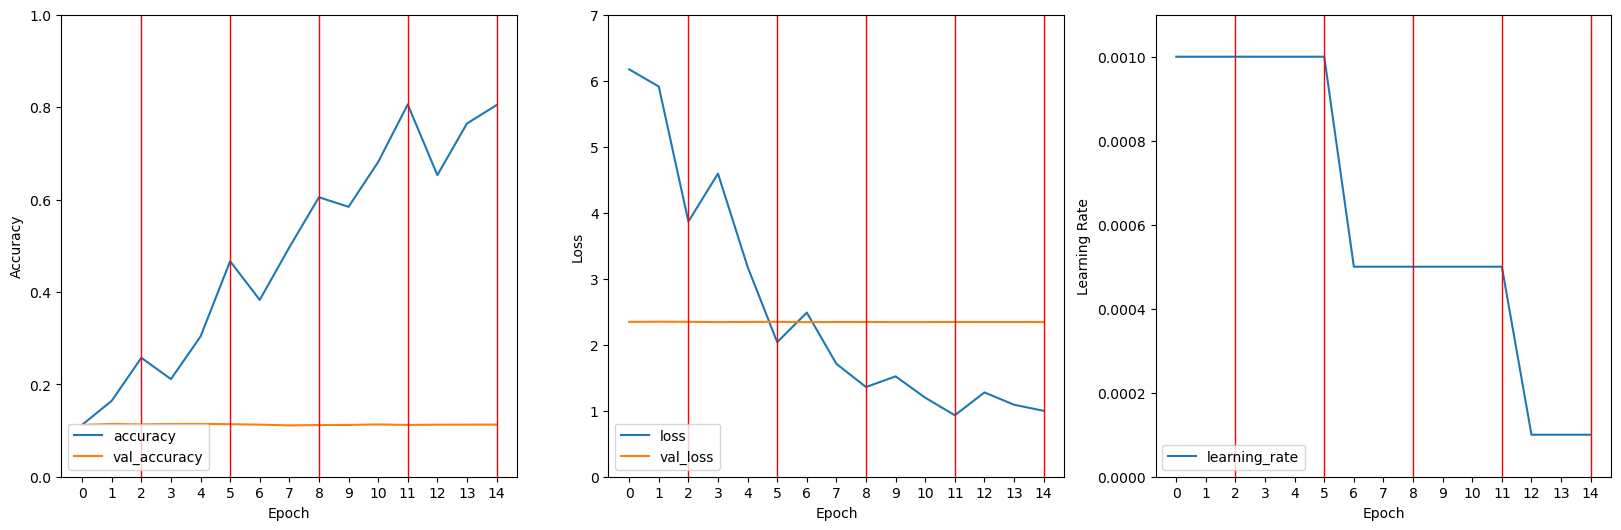

In [140]:
n_epochs = len(merged_histories["loss"])
x_ticks = np.arange(0, n_epochs, 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(merged_histories["accuracy"], label="accuracy")
plt.plot(merged_histories["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

plt.subplot(1, 3, 2)
plt.plot(merged_histories["loss"], label="loss")
plt.plot(merged_histories["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0, 7])
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

plt.subplot(1, 3, 3)
plt.plot(merged_histories["learning_rate"], label="learning_rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.ylim([0, LEARNING_RATE + LEARNING_RATE / 10]) # Learning rate is a small float (overflowing) - to see start, add some to the top
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

### Load model from disk to get reproducible results

In [123]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [124]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [125]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [126]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [127]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

2025-04-24 14:13:38.693925: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-24 14:13:39.403403: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[9,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,128,5,5]{3,2,1,0}, f32[32,128,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudn

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[4 4 3 8 6 4 9 7 1]
 [7 8 7 1 3 6 3 1 6]
 [1 5 7 2 7 5 3 8 7]
 [4 3 3 6 4 1 6 5 8]
 [9 8 4 4 5 5 8 1 2]
 [7 3 5 3 2 1 7 4 6]
 [2 8 9 1 6 9 5 1 6]
 [9 5 8 7 3 7 7 1 3]
 [1 7 6 6 3 8 6 1 2]]


In [128]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1745496821.376837   96745 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1111 - loss: 2.3452


In [129]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[9 7 9 8 6 4 9 7 1]
 [7 4 7 1 3 6 3 3 6]
 [1 5 7 2 7 9 3 8 5]
 [4 3 3 6 4 1 6 5 8]
 [9 8 4 4 9 5 9 1 4]
 [1 6 5 3 2 1 7 4 6]
 [2 8 9 1 6 9 5 1 6]
 [9 7 8 7 8 7 7 1 3]
 [2 8 6 6 5 8 6 4 2]]


In [130]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1358 - loss: 2.3391


0.1358024775981903

### Evaluate test set performance

In [131]:
loss, accuracy = model.evaluate(test_dataset)

W0000 00:00:1745496822.974138   96740 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1148 - loss: 2.3432

W0000 00:00:1745496823.786141   96742 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.1147 - loss: 2.3432


In [132]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.11404937505722046 and loss: 2.3431310653686523


The End